In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn as nn
import argparse, os, json, sys
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from torch.utils.data import Dataset
import h5py
from EvalTools import *
sys.path.append("../model")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
from EvalTools import uncertainty_plot
import gc
import seaborn as sns
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#optional parameters to only evaluate certain models
optional_dataset = 'topdata'
optional_tag = ''
results_dir = 'results/'
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"

result_files = sorted([f for f in os.listdir(results_dir) if optional_dataset in f and optional_tag in f
                      and "Ensemble" in f and '.h5' in f])
print('\n'.join(result_files))

RESULTS_UQPFIN_Ensemble_topdata_baseline.h5


In [4]:
for modelname in result_files:
    model_results = {}
    mname = modelname[15:-3]
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")
    labels, preds, oods, probs, uncs = f['labels'][:], f['preds'][:], f['oods'][:], f['probs'][:], f['uncs'][:]
    f.close()
    acc = accuracy_score(labels[~oods], preds[~oods])*100
    if "topdata" in mname:
        probs2=probs
    else:
        skiplabels = np.unique(labels[oods])
        probs2=np.delete(probs, skiplabels, 1)

    if probs2.shape[1] == 2:
        probs2 = probs2[:, 1]
        
    # misclassification detection vs out-of-distribution detection
    if "baseline" in mname:
        oods = labels != preds

    auc = roc_auc_score(oods, uncs) * 100
    del model_results
    gc.collect()
    
    print("{} \t\t Accuracy: {:.2f}% \t AUROC: {:.2f}%".format(mname, acc, auc))    

Ensemble_topdata_baseline 		 Accuracy: 93.66% 	 AUROC: 89.00%


Ensemble_topdata_baseline


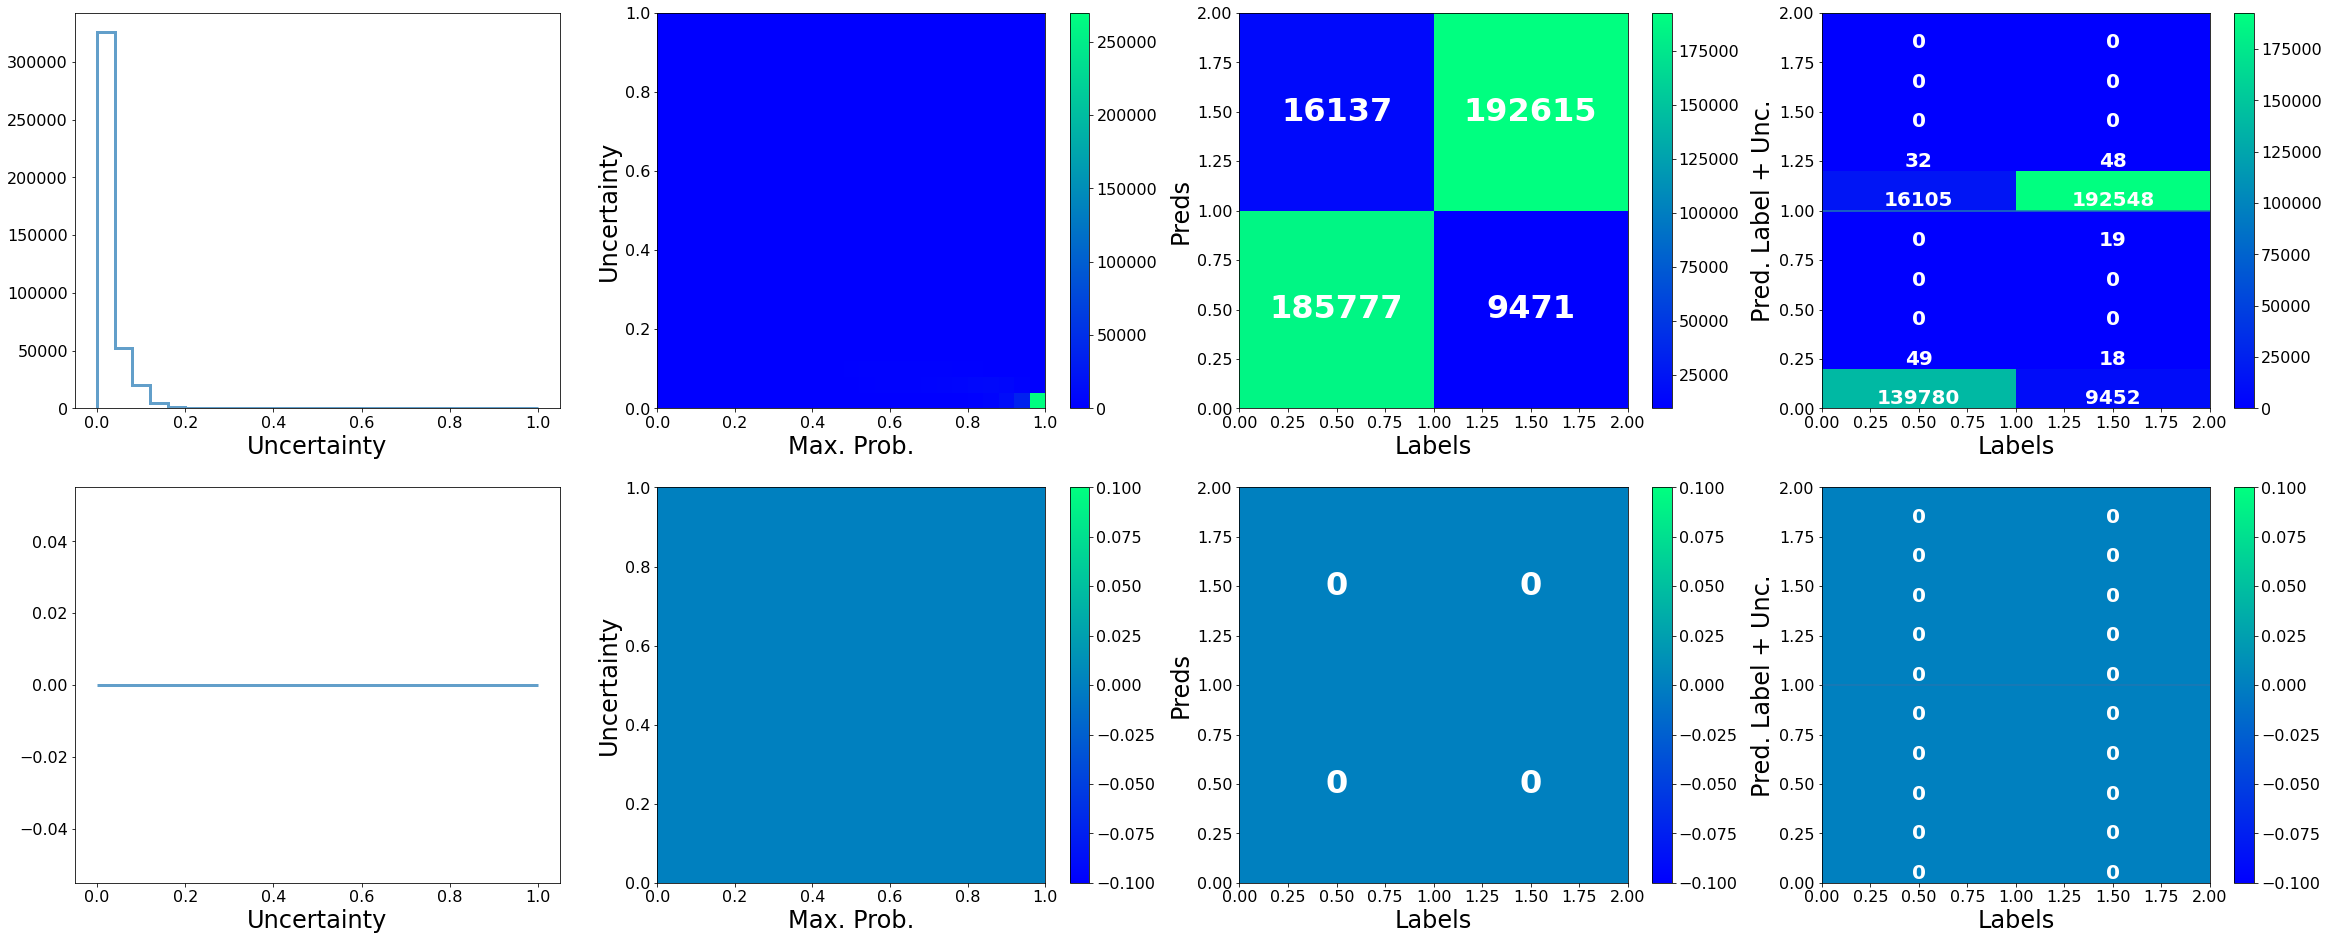

In [5]:
for modelname in result_files:
    key = modelname[15:-3]
    print(key)
    if "jetnet" in key:
        l_max = 5.1
        asize=16
        asize2=12
        
    elif "jetclass" in key:
        l_max = 10.1
        asize="small"
        asize2=8
    
    elif "JNqgmerged" in key:
        l_max = 4.1
    else:
        l_max = 2.1
        asize=32
        asize2=20
    
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")    
    labels, preds, maxprobs, sums, oods, uncs, probs = f['labels'][:], f['preds'][:], \
                                                f['maxprobs'][:], f['sums'][:], \
                                                f['oods'][:], f['uncs'][:], f['probs'][:]
    f.close()
    
    fsize=24
    tsize=16
    
    #epistemic uncertainty
    uncertainty_plot(uncs, oods, maxprobs, labels, preds, key, l_max, fsize, tsize, asize, asize2)
    # plt.savefig("figures/Ensemble_{}.pdf".format(key))
    plt.show()

Ensemble_topdata_baseline


/tmp/ipykernel_681545/2993496973.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{int(tick / 1000)}k' for tick in tick_values])
/tmp/ipykernel_681545/2993496973.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_681545/2993496973.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{int(tick / 1000)}k' for tick in tick_values])
/tmp/ipykernel_681545/2993496973.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_681545/2993496973.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{int(tick / 1000)}k' for tick in tick_values])
/tmp/ipykernel_681545/2993496973.py:145: UserWarning: This figure includes Axes that a

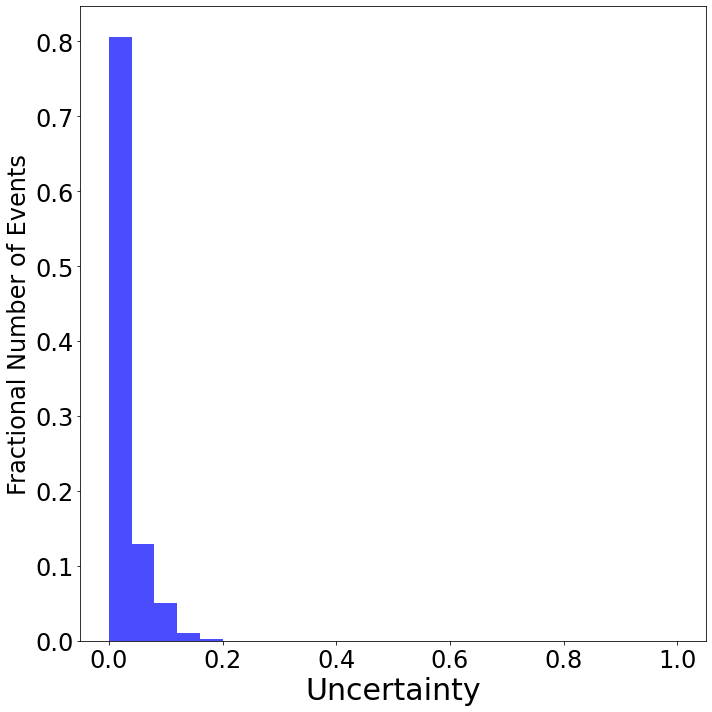

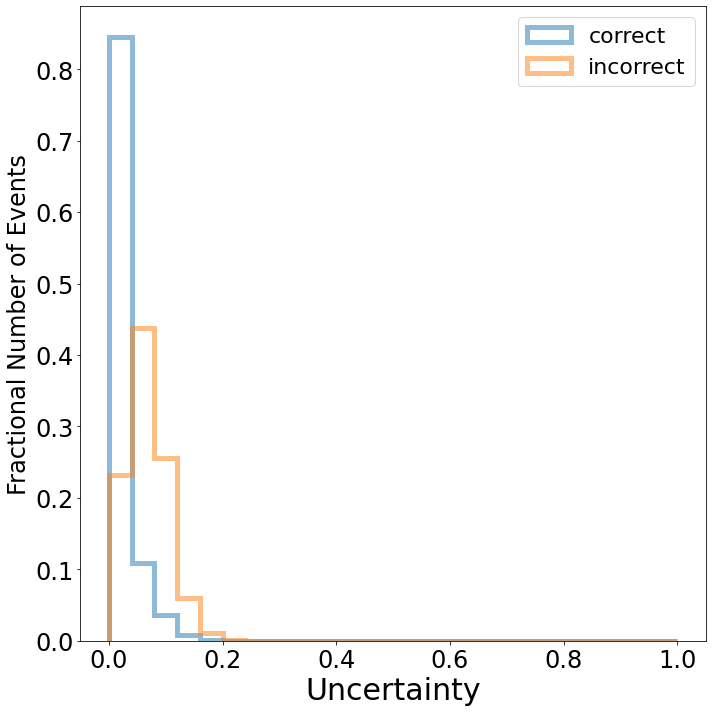

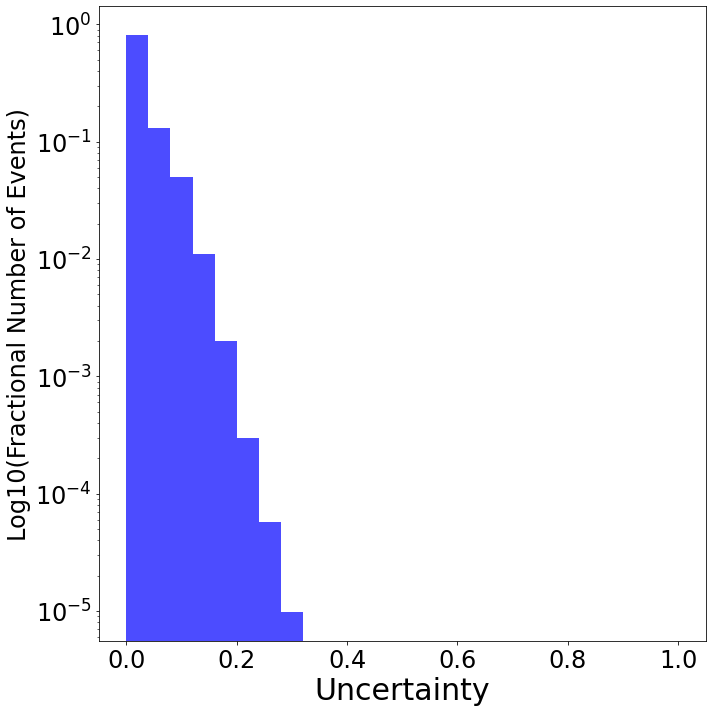

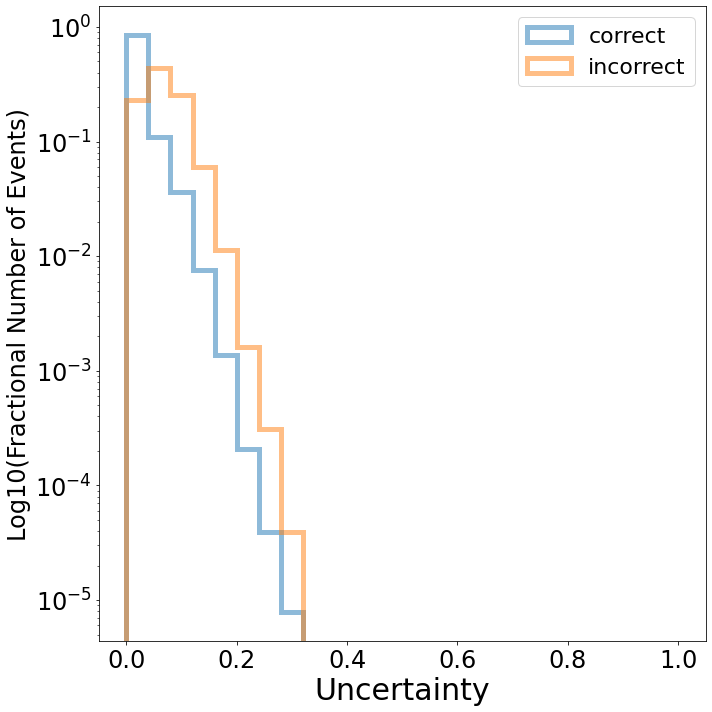

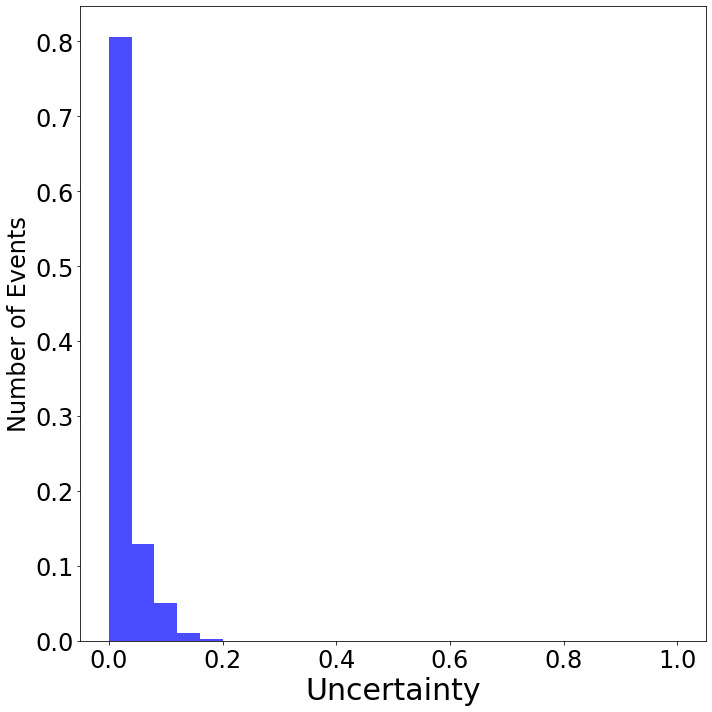

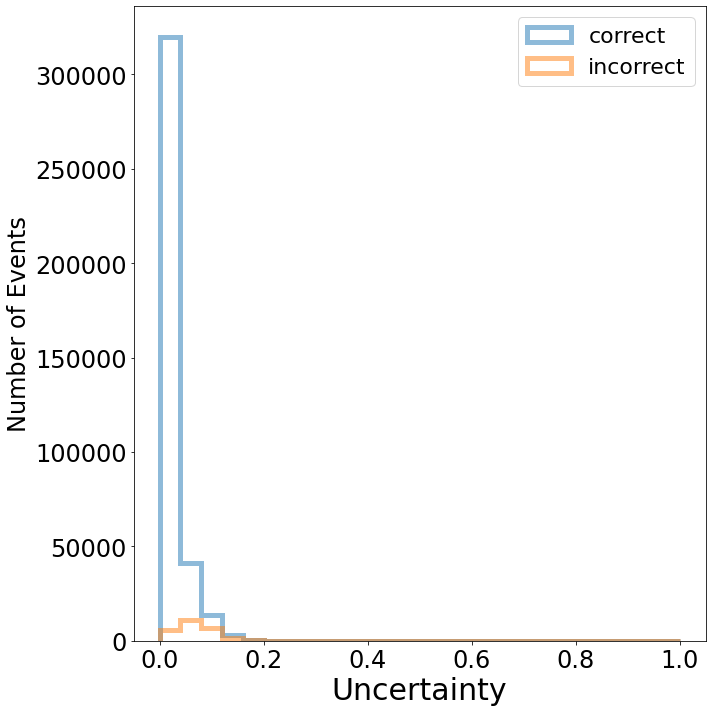

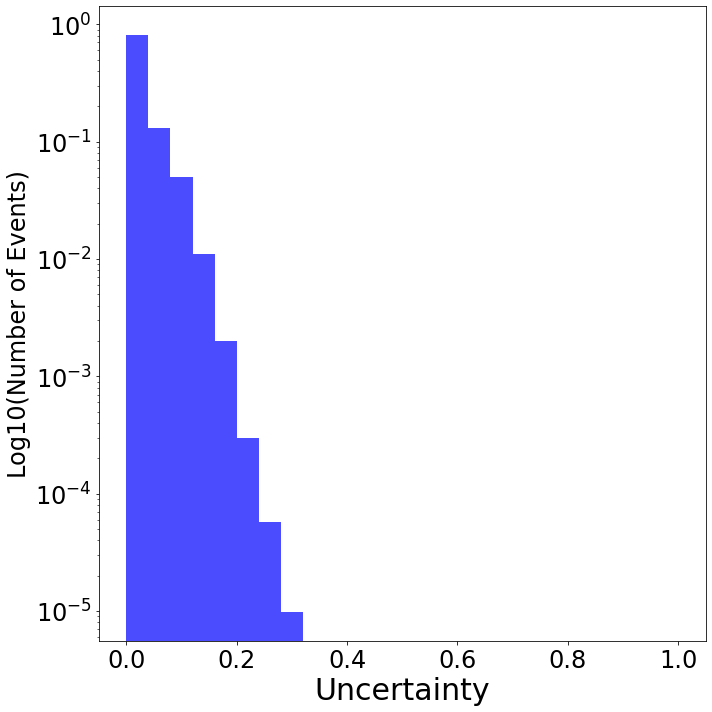

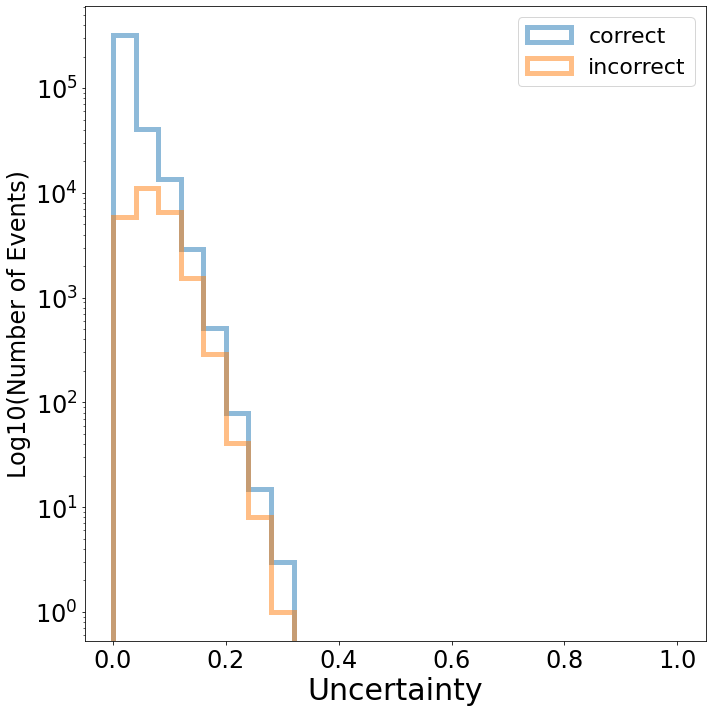

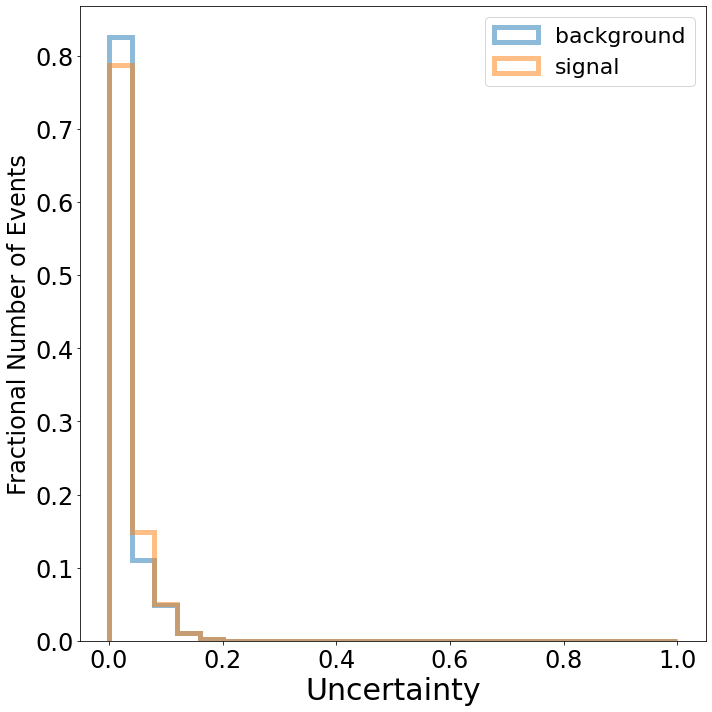

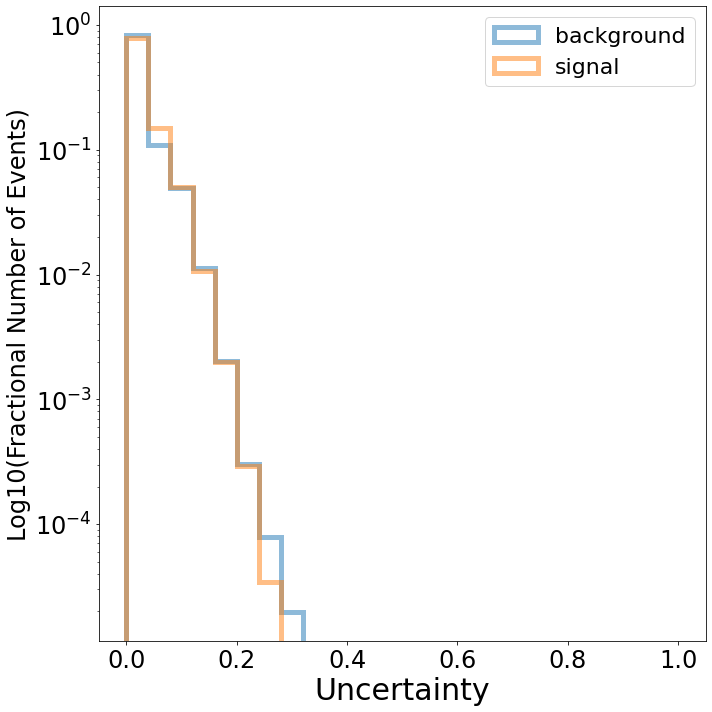

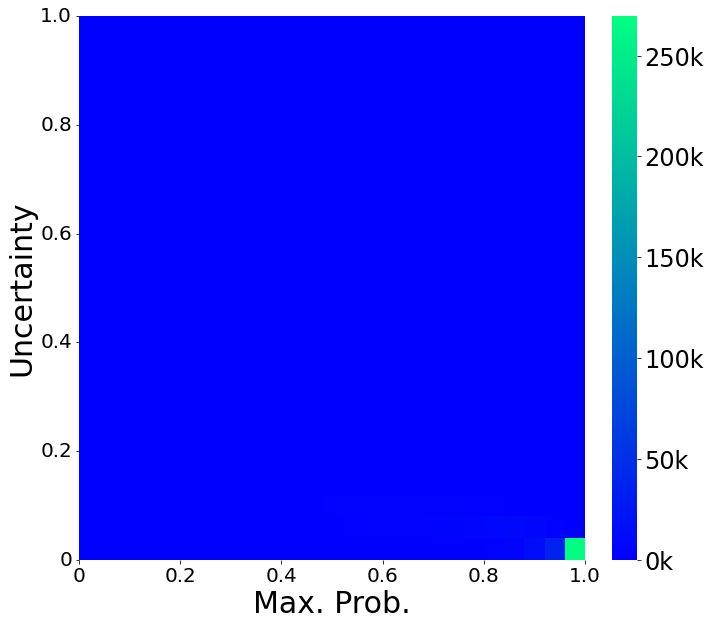

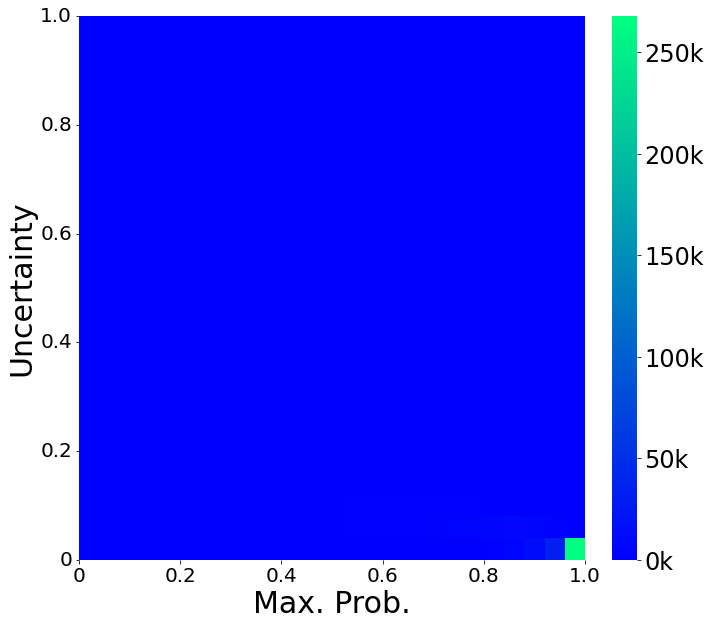

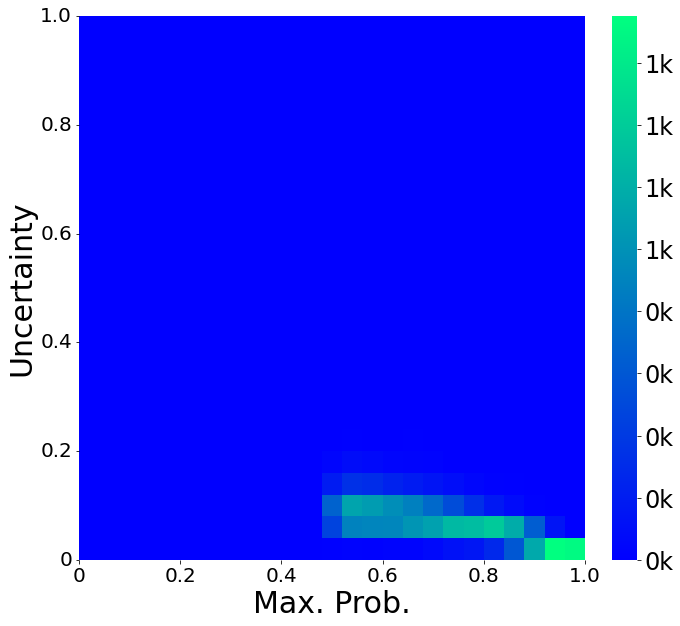

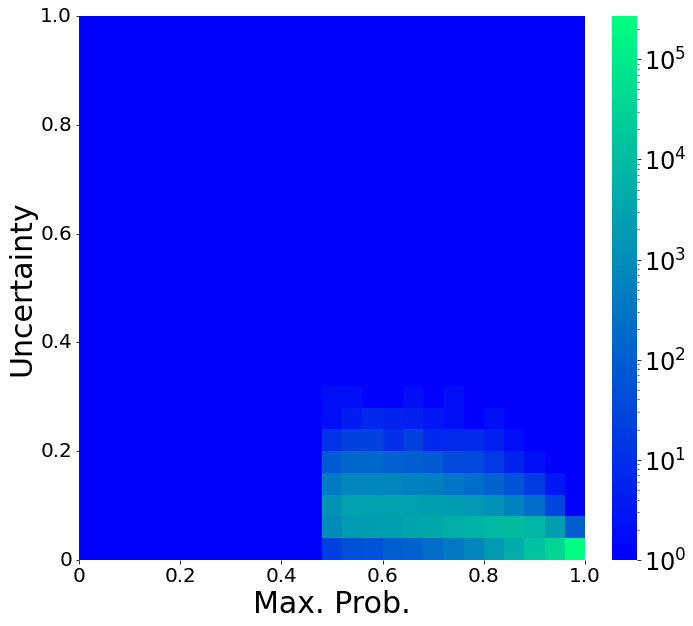

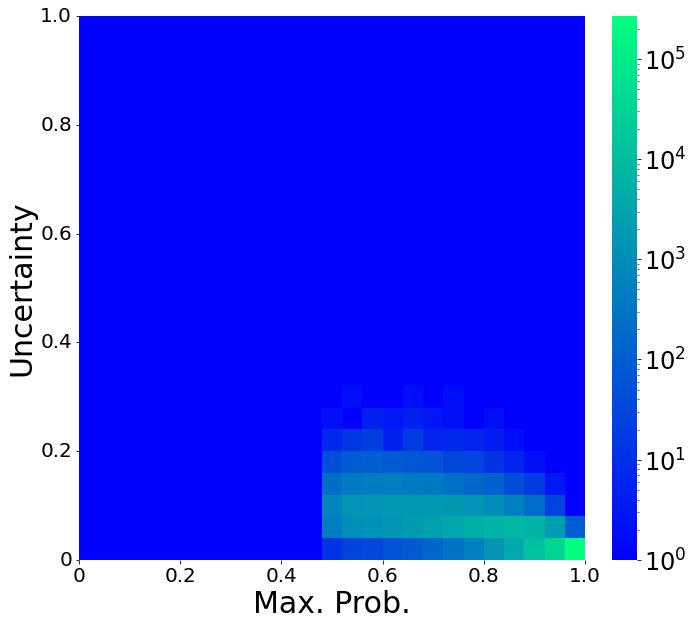

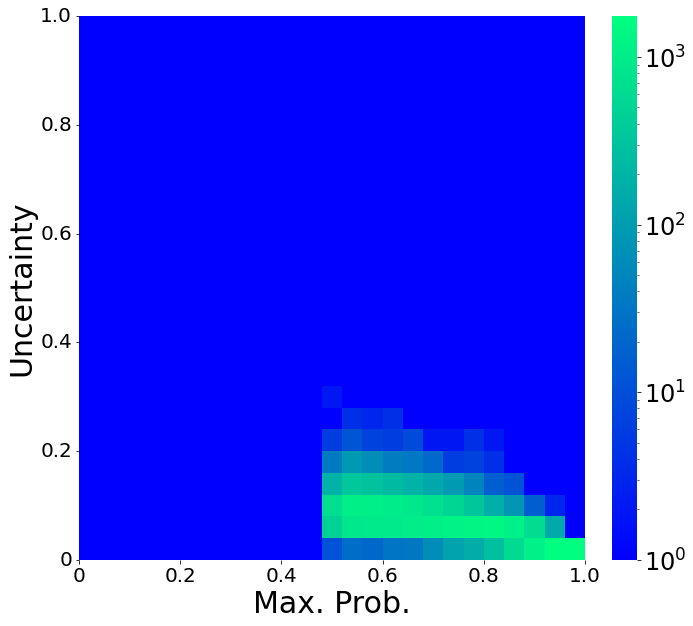

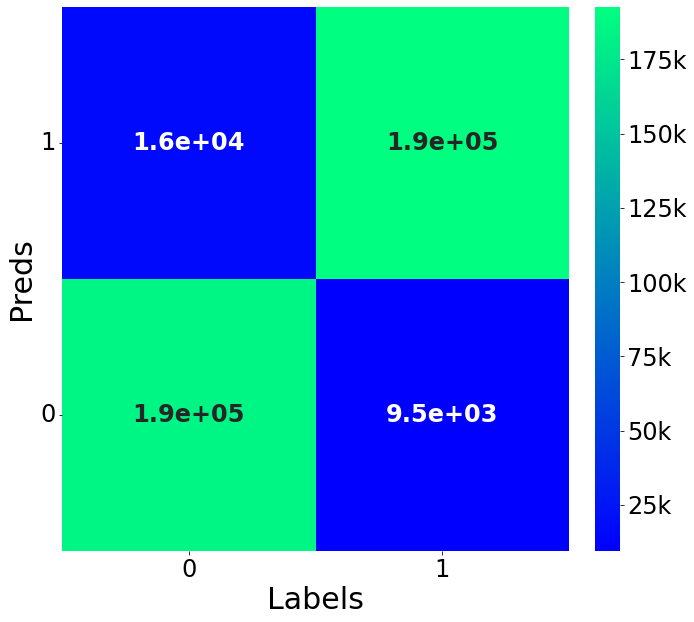

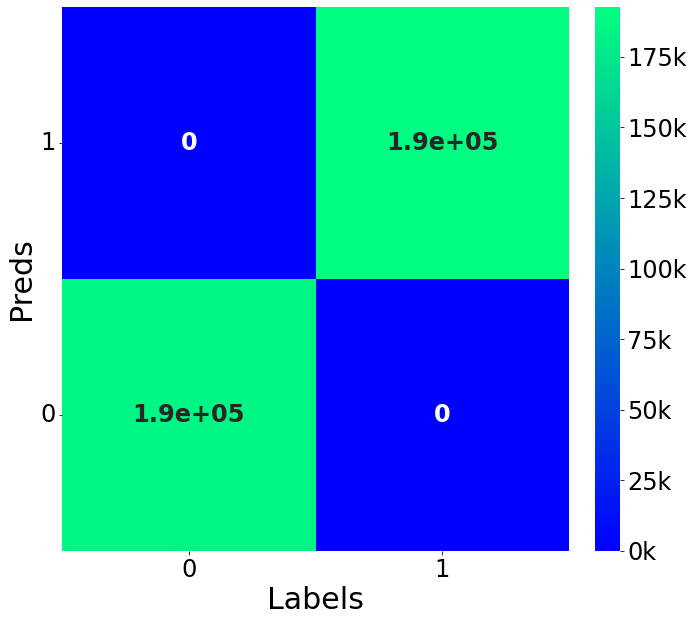

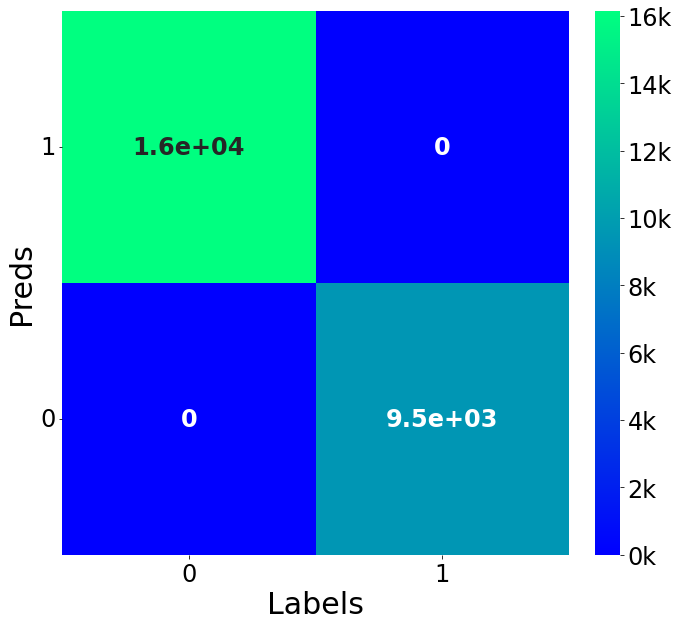

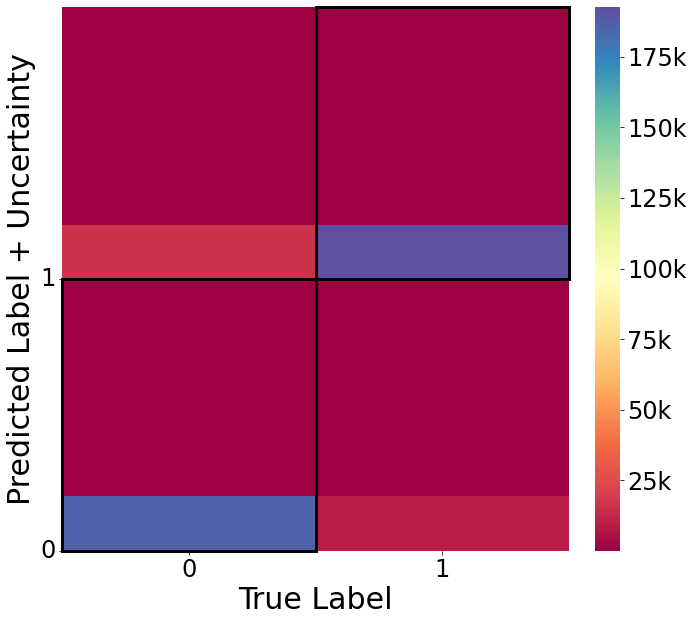

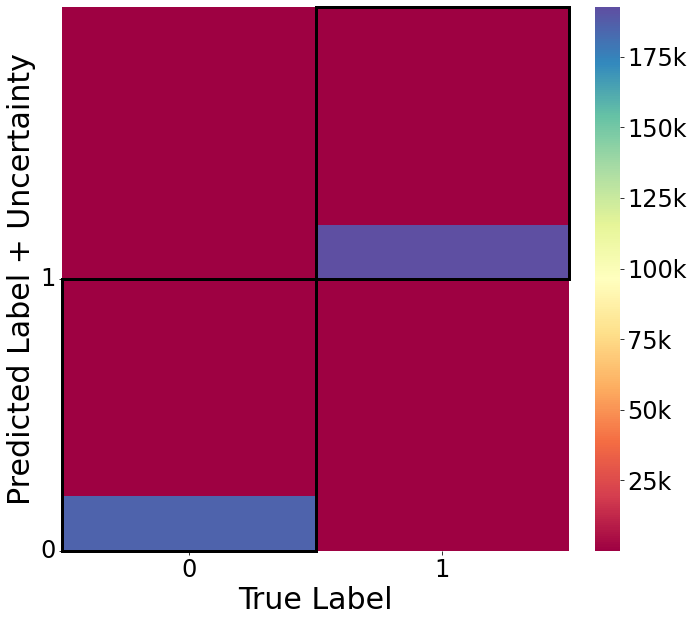

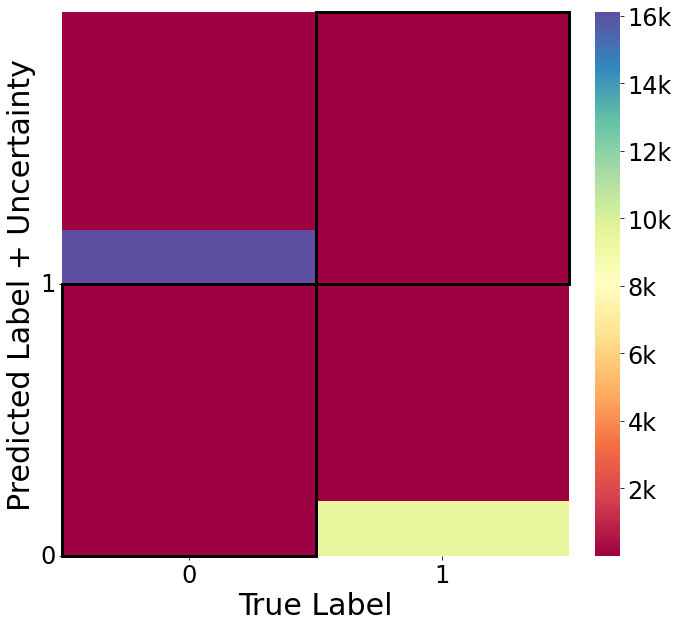

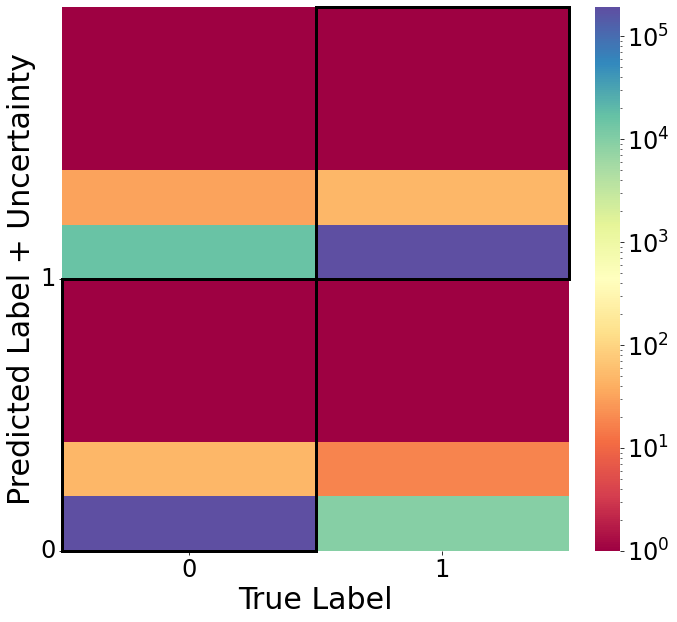

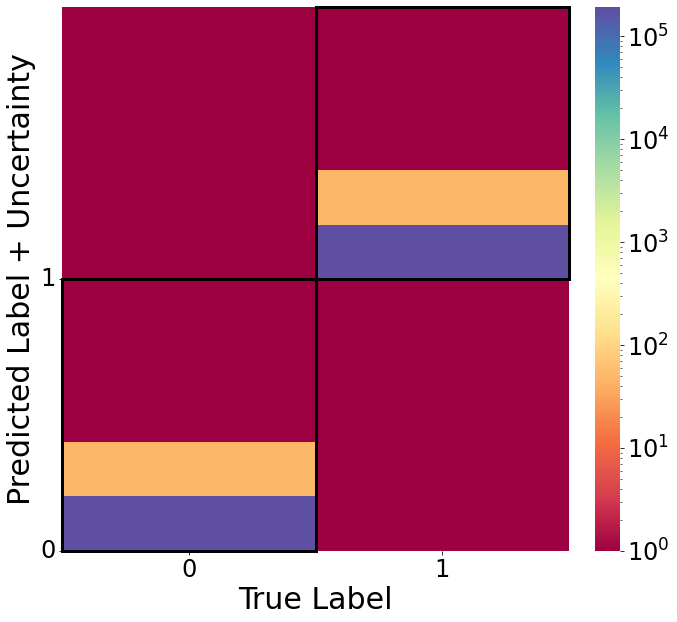

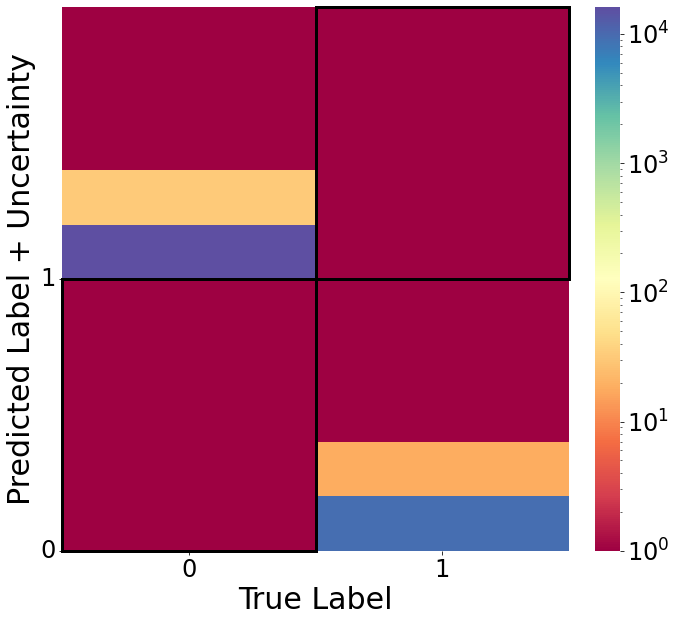

In [6]:
for modelname in result_files:
    key = modelname[15:-3] 
    print(key)
    
    if "jetnet" in key:
        l_max = 5
        fsize=18
        groups = ['QCD', 'QCD', 'Top', 'Bosons', 'Bosons']
    elif "jetclass" in key:
        l_max = 10
        fsize=10
        groups = ['QCD', 'Higgs', 'Higgs', 'Higgs', 'Higgs', 'Higgs', 'Bosons', 'Bosons', 'Top', 'Top']
    elif "JNqgmerged" in key:
        l_max = 4
    else:
        l_max = 2
        fsize=24
        groups = ["background", "signal"]
    groups = np.array(groups)
        
    uniq_names, ind = np.unique(groups, return_index=True)
    uniq_names = uniq_names[np.argsort(ind)]
        
        
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")    
    labels, preds, maxprobs, sums, oods, uncs, probs = f['labels'][:], f['preds'][:], \
                                                f['maxprobs'][:], f['sums'][:], \
                                                f['oods'][:], f['uncs'][:], f['probs'][:]
    f.close()
    
    split = key.split('_')
    
    savefolder = "figures/{}/{}/{}/".format(split[0], split[1], split[2])
    os.makedirs(savefolder, exist_ok=True)

    if 'baseline' in key:
        f1 = 'correct'
        f2 = 'incorrect'
        oods = labels != preds
    else:
        f1 = 'id'
        f2 = 'ood'


    mult_label = "Unc"

    for types in ['total', 'separate', 'total_log', 'separate_log']:
        # Uncertainty distribution
        plt.figure(figsize=(10,10))
        ax = plt.gca()

        if 'total' in types:
            ax.hist(uncs, bins=np.arange(0.,1.01,0.04), alpha = 0.7, color='blue', weights = (1./len(uncs)) * np.ones_like(uncs))
        else:
            ax.hist(uncs[~oods], bins=np.arange(0.,1.01,0.04), label=f1, alpha = 0.5, histtype = 'step', linewidth = 5, weights = (1./len(uncs[~oods])) * np.ones_like(uncs[~oods]))
            ax.hist(uncs[oods], bins=np.arange(0.,1.01,0.04), label=f2, alpha = 0.5, histtype = 'step', linewidth = 5, weights = (1./len(uncs[oods])) * np.ones_like(uncs[oods]))
            ax.legend(fontsize = 22)
        # ax.set_aspect((ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
        ax.set_xlabel("Uncertainty".replace("Unc", mult_label), fontsize=30)
        ax.set_ylabel("Fractional Number of Events", fontsize = 24)
        if 'log' in types:
            ax.set_ylabel("Log10(Fractional Number of Events)", fontsize = 24)
            ax.set_yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.yaxis.get_offset_text().set_fontsize(24)
        plt.tight_layout()
        plt.savefig("{}/unc_normal_{}.pdf".format(savefolder, types), dpi = 150, bbox_inches='tight')


    for types in ['total', 'separate', 'total_log', 'separate_log']:
        # Uncertainty distribution
        plt.figure(figsize=(10,10))
        ax = plt.gca()

        if 'total' in types:
            ax.hist(uncs, bins=np.arange(0.,1.01,0.04), alpha = 0.7, color='blue', weights = (1./len(uncs)) * np.ones_like(uncs))
        else:
            ax.hist(uncs[~oods], bins=np.arange(0.,1.01,0.04), label=f1, alpha = 0.5, histtype = 'step', linewidth = 5)
            ax.hist(uncs[oods], bins=np.arange(0.,1.01,0.04), label=f2, alpha = 0.5, histtype = 'step', linewidth = 5)
            ax.legend(fontsize = 22)
        # ax.set_aspect((ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
        ax.set_xlabel("Uncertainty".replace("Unc", mult_label), fontsize=30)
        ax.set_ylabel("Number of Events", fontsize = 24)
        if 'log' in types:
            ax.set_ylabel("Log10(Number of Events)", fontsize = 24)
            ax.set_yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.yaxis.get_offset_text().set_fontsize(24)
        plt.tight_layout()
        plt.savefig("{}/unc_{}.pdf".format(savefolder, types), dpi = 150, bbox_inches='tight')


    for types in ['normal', 'log']:
        # Uncertainty distribution
        plt.figure(figsize=(10,10))
        ax = plt.gca()

        for i in range(len(uniq_names)):
            indices = np.in1d(labels, np.where(groups == uniq_names[i])[0])
            if np.any(indices & oods) and "skip" in key:
                lstyle = '--'
                lbel = f"{uniq_names[i]} (OOD)"
            else:
                lstyle = '-'
                lbel = uniq_names[i]
            ax.hist(uncs[indices], bins=np.arange(0.,1.01,0.04), label=lbel, alpha = 0.5, histtype = 'step', linewidth = 5, linestyle = lstyle, weights = (1./len(uncs[indices])) * np.ones_like(uncs[indices]))
        ax.legend(fontsize = 22)
        # ax.set_aspect((ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
        ax.set_xlabel("Uncertainty".replace("Unc", mult_label), fontsize=30)
        ax.set_ylabel("Fractional Number of Events", fontsize = 24)
        if 'log' in types:
            ax.set_ylabel("Log10(Fractional Number of Events)", fontsize = 24)
            ax.set_yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.yaxis.get_offset_text().set_fontsize(24)
        plt.tight_layout()
        plt.savefig("{}/unc_class_{}.pdf".format(savefolder, types), dpi = 150, bbox_inches='tight')


    filetypes = ['total', f1, f2]
    indices = [oods | ~oods, ~oods, oods]

    for filetype, idx in zip(filetypes, indices):
        # Max Prob. vs Uncertainty distribution
        hist, _, _ = np.histogram2d(maxprobs[idx], uncs[idx], bins = [np.arange(0.,1.01,0.04), np.arange(0.,1.01,0.04)])

        fig, ax  = plt.subplots(1, 2, figsize=(10,10), gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1})
        heatmap = sns.heatmap(hist.T, annot=False, cmap='winter', ax=ax[0], cbar_ax=ax[1])
        ax[0].invert_yaxis()
        ax[0].set_xlabel("Max. Prob.", fontsize=30)
        ax[0].set_ylabel("Uncertainty".replace("Unc", mult_label), fontsize=30)
        ax[0].set_yticks(np.arange(0, 26, 5))
        ax[0].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], rotation=0)
        ax[0].set_xticks(np.arange(0, 26, 5))
        ax[0].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax[0].tick_params(axis='both', which='major', labelsize=20)
        cbar = heatmap.collections[0].colorbar
        cbar.ax.tick_params(labelsize=24)
        cbar.ax.yaxis.get_offset_text().set_fontsize(24)
        if 'topdata' in key or 'jetnet' in key:
            tick_values = cbar.get_ticks()
            cbar.set_ticklabels([f'{int(tick / 1000)}k' for tick in tick_values])
        plt.tight_layout()
        plt.savefig("{}/unc_prob_{}.pdf".format(savefolder, filetype), dpi = 150, bbox_inches='tight')

    for filetype, idx in zip(filetypes, indices):
        # Max Prob. vs Uncertainty distribution (Log Scale)
        hist, _, _ = np.histogram2d(maxprobs[idx], uncs[idx], bins = [np.arange(0.,1.01,0.04), np.arange(0.,1.01,0.04)])

        fig, ax  = plt.subplots(1, 2, figsize=(10,10), gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1})
        heatmap = sns.heatmap(hist.T+1, annot=False, cmap='winter', ax=ax[0], cbar_ax=ax[1], norm=LogNorm())
        ax[0].invert_yaxis()
        ax[0].set_xlabel("Max. Prob.", fontsize=30)
        ax[0].set_ylabel("Uncertainty".replace("Unc", mult_label), fontsize=30)
        ax[0].set_yticks(np.arange(0, 26, 5))
        ax[0].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], rotation=0)
        ax[0].set_xticks(np.arange(0, 26, 5))
        ax[0].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax[0].tick_params(axis='both', which='major', labelsize=20)
        cbar = heatmap.collections[0].colorbar
        cbar.ax.tick_params(labelsize=24)
        plt.tight_layout()
        plt.savefig("{}/unc_prob_{}_log.pdf".format(savefolder, filetype), dpi = 150, bbox_inches='tight')

    for filetype, idx in zip(filetypes, indices):
        # Labels vs Preds
        arr = np.zeros((l_max,l_max))
        for i in range(l_max):
            for j in range(l_max):
                arr[j, i] = np.sum((labels[idx] == i) & (preds[idx] == j))

        fig, ax  = plt.subplots(1, 2, figsize=(10,10), gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1})
        heatmap = sns.heatmap(arr, annot=True, cmap='winter', annot_kws={"size": fsize, "weight": "bold"}, ax=ax[0], cbar_ax=ax[1])
        ax[0].invert_yaxis()
        ax[0].set_xlabel("Labels", fontsize=30)
        ax[0].set_ylabel("Preds", fontsize=30)
        ax[0].tick_params(axis='both', which='major', labelsize=24)
        ax[0].tick_params(axis='y', labelrotation=0)
        cbar = heatmap.collections[0].colorbar
        cbar.ax.tick_params(labelsize=24)
        cbar.ax.yaxis.get_offset_text().set_fontsize(24)
        if 'topdata' in key or 'jetnet' in key:
            tick_values = cbar.get_ticks()
            cbar.set_ticklabels([f'{int(tick / 1000)}k' for tick in tick_values])
        plt.tight_layout()
        plt.savefig("{}/labels_preds_{}.pdf".format(savefolder, filetype), dpi = 150, bbox_inches='tight')

    for types in ['normal', 'log']:
        for filetype, idx in zip(filetypes, indices):
            # Labels vs Preds + Uncertainty
            uncertainty_bins = np.zeros((5*l_max, l_max))  # 5 bins for uncertainty
            for i in range(l_max):
                for j in range(l_max):
                    filtered_indices = (labels[idx] == i) & (preds[idx] == j)
                    if np.sum(filtered_indices) > 0:
                        # Create histogram for uncertainty values in 5 bins
                        hist, _ = np.histogram(uncs[idx][filtered_indices], bins=5, range=(0, 1))
                        for k in range(5):
                            uncertainty_bins[5*j+k, i] = hist[k]

            fig, ax  = plt.subplots(1, 2, figsize=(10,10), gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1})
            if 'log' in types:
                norm = LogNorm()
            else:
                norm = None
            uncertainty_bins_clean = np.where(uncertainty_bins == 0, 1, uncertainty_bins)
            heatmap = sns.heatmap(uncertainty_bins_clean, annot=False, cmap='Spectral', annot_kws={"size": fsize, "weight": "bold"}, ax=ax[0], cbar_ax=ax[1], norm=norm)
            ax[0].invert_yaxis()
            uacm_axsize = 30
            if "jetclass" in key:
                uacm_axsize = 20
            ax[0].set_xlabel("True Label", fontsize=uacm_axsize)
            ax[0].set_ylabel("Predicted Label + Uncertainty".replace("Unc", mult_label), fontsize=uacm_axsize)
            for jj in np.arange(5,5*l_max, 5):
                ax[0].axhline(jj, linewidth=3, color='white', zorder=1)
                ax[0].axvline(jj//5, linewidth=3, color='white', zorder=1)
            for i in range(l_max):
                ax[0].add_patch(
                    plt.Rectangle((i, 5*i), 1, 5,
                                  fill=False, edgecolor='black', linewidth=3, zorder=3, clip_on=False)
                )

            ax[0].set_yticks(np.arange(0, 5*l_max, 5))
            ax[0].set_yticklabels(np.arange(0, l_max), rotation=0)
            uacm_fsize = 24
            if "jetclass" in key:
                uacm_fsize = 16
            ax[0].tick_params(axis='both', which='major', labelsize=uacm_fsize)
            cbar = heatmap.collections[0].colorbar
            cbar.ax.tick_params(labelsize=uacm_fsize)
            cbar.ax.yaxis.get_offset_text().set_fontsize(uacm_fsize)
            if ('topdata' in key or 'jetnet' in key) and 'normal' in types:
                tick_values = cbar.get_ticks()
                cbar.set_ticklabels([f'{int(tick / 1000)}k' for tick in tick_values])
            plt.tight_layout()
            plt.savefig("{}/labels_preds_unc_{}.pdf".format(savefolder, filetype), dpi = 150, bbox_inches='tight')